# Projet - Connaissances et Raisonnement
**Élèves** : Andris Oueslati, Arij Ben Rhouma

# 🗓️ Planification de Réunions avec SAT/MaxSAT

**Objectif** : Déterminer un créneau optimal pour une réunion en tenant compte des contraintes de disponibilité, de durée, d'importance des conflits, et des pauses (ex: 12h-14h).  


## 📚 Structure du Notebook
***Partie 1 – Modèle SAT de Base*** \
Déterminer un créneau unique où **tous** les participants sont disponibles, sans chevauchement avec la pause de midi.<br>

***Partie 2 – Modèle avec Importance*** \
Maintenant, les participants ont différentes réunions avec des niveaux d'importance différents. On veut sélectionner un créneau en minimisant la **somme des priorités** des réunions conflictuelles, en autorisant certains conflits "tolérables". Ainsi, une réunion de haute importance pourra remplacer des réunions d'importance plus faibes.<br>

***Partie 3 – Approche MaxSAT*** \
Utiliser des **clauses souples** pour identifier le créneau avec le **coût global minimal**, en priorisant automatiquement les conflits les moins critiques. Cela permet une éxécution plus rapide.


# 0 - Fonction utilitaires
### Importation des bibliothèques

In [26]:

import os
import sys
# installation des paquets
#!{sys.executable} -m pip install -r requirements.txt 

import csv
from itertools import combinations
import time
from pysat.solvers import Glucose3
import random
import shutil
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

### Variables globales de configuration

In [27]:
# Configuration
GOPHERSAT_PATH = r"gophersat.exe"  # chemin vers le solveur gophersat
SCHEDULES_DIR = r"schedules"      # Dossier des emplois du temps cas simple
SCHEDULES_IMP_DIR = r"schedules_imp"      # Dossier des emplois du temps avec importance
DURATION = 30             # Durée de la réunion en minutes (15, 30, 45, 60)
IMPORTANCE = 3
DEBUT_PAUSE = "12:00"
FIN_PAUSE = "14:00"
NUM_PARTICIPANTS = 3

### Génération et suppression des emplois du temps

In [28]:
JOURS = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi"]
HORAIRES = [
    "9:00", "9:15", "9:30", "9:45", "10:00", "10:15", "10:30", "10:45",
    "11:00", "11:15", "11:30", "11:45", "14:00", "14:15", "14:30", "14:45",
    "15:00", "15:15", "15:30", "15:45", "16:00", "16:15", "16:30", "16:45"
]

def generer_schedules(nb_fichiers,n,dir):
    """ Génère `nb_fichiers` emplois du temps aléatoires en CSV dans le dossier dir, avec n>= 1 si on prend en compte l'importance. """

    os.makedirs(dir, exist_ok=True)  # Créer le dossier s'il n'existe pas

    for i in range(1, nb_fichiers + 1):
        fichier_path = os.path.join(dir, f"schedule{i}.csv")

        with open(fichier_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            
            # en-tête
            writer.writerow(["Jour"] + HORAIRES)
            
            # Générer les emplois du temps
            if n>=1: #on prend en compte l'importance
                for jour in JOURS:
                    ligne = [jour]
                    for _ in HORAIRES:
                        if random.random() < 0.3:  # 30% de chances d'avoir un 0
                            ligne.append(0)
                        else:
                            ligne.append(random.randint(1, 5))  # Valeur entre 1 et 5
                    writer.writerow(ligne)
            else:
                for jour in JOURS:
                    ligne = [jour]
                    for _ in HORAIRES:
                        ligne.append(random.randint(0,1))  # Valeur entre 0 et 1
                    writer.writerow(ligne)


        print(f"Fichier généré : {fichier_path}")


def clear_schedules_dir(directory):
    """Supprime et recrée le dossier des schedules en gérant les erreurs d'accès."""
    if os.path.exists(directory):
        try:
            shutil.rmtree(directory)
        except PermissionError as e:
            # Optionnel : suppression manuelle des fichiers
            for root, dirs, files in os.walk(directory, topdown=False):
                for name in files:
                    try:
                        os.remove(os.path.join(root, name))
                    except Exception as e:
                        print(f"Impossible de supprimer le fichier {name}: {e}")
                for name in dirs:
                    try:
                        os.rmdir(os.path.join(root, name))
                    except Exception as e:
                        print(f"Impossible de supprimer le dossier {name}: {e}")
            
    os.makedirs(directory, exist_ok=True)


### Lecture des emplois du temps

In [29]:
def lire_emplois_du_temps(dossier):
    """
    Lit tous les fichiers CSV dans le dossier et retourne :
      - emplois : un dictionnaire où chaque clé correspond à un participant et
                  la valeur est un dictionnaire {jour: {horaire: statut}}
                  Le statut est un entier de 0 à 5.
                  0 indique que le participant est disponible,
                  1 indique que le participant à une réunion
                  2 à 5 représentent des réunions avec des niveaux d'importance croissante(pour la partie 2)
      - jours : la liste des jours considérés
      - horaires : la liste des horaires (extrait du header des CSV)
    """
    
    fichiers = [f for f in os.listdir(dossier) if f.endswith(".csv")]
    if not fichiers:
        raise FileNotFoundError("Aucun fichier CSV trouvé dans le dossier")

    jours = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi"]
    emplois = {}  # clé : identifiant du participant, valeur : emploi du temps
    horaires = None

    for fichier in fichiers:
        with open(os.path.join(dossier, fichier), 'r', encoding='utf-8') as f:
            lecteur = csv.reader(f)
            header = next(lecteur)
            # La première colonne est "Jour", le reste sont les horaires
            if horaires is None:
                horaires = header[1:]
            emploi = {}  
            for ligne in lecteur:
                jour = ligne[0]
                if jour not in jours:
                    continue
                # Pour chaque jour, créer un dictionnaire {horaire: statut}
                emploi[jour] = {}

                if dossier==SCHEDULES_DIR or dossier==SCHEDULES_IMP_DIR:

                    for i, statut in enumerate(ligne[1:]):
                        # Convertir le statut en entier (0 pour libre, 1 pour occupé)
                        emploi[jour][horaires[i]] = int(statut)

                else:

                    for i, statut in enumerate(ligne[1:]):
                        importance = int(statut)
                        if not 0 <= importance <= 5:
                            raise ValueError(f"Valeur de statut invalide {importance} dans le fichier {fichier} "
                                f"pour le jour {jour} et l'horaire {horaires[i]}")
                        emploi[jour][horaires[i]] = importance

            emplois[fichier] = emploi

    return emplois, jours, horaires

### Affichage des solutions

In [30]:
def afficher_resultats_detailles(solutions, Y_vars, emplois, jours, horaires, duree):
    """
    Affiche les résultats détaillés pour toutes les solutions trouvées.
    
    Deux formats sont supportés :
      - Format 1 : (solution, cost, (jour, horaire))
      - Format 4 : (solution,)
    
    Pour le format 1, le jour, l'horaire de début et le coût sont fournis.
    Pour le format 4, on déduit l'horaire à partir des variables Y positives.
    
    :param solutions: Liste de solutions (tuples).
    :param Y_vars: Dictionnaire {(jour, horaire): var} des variables Y du modèle CNF.
    :param emplois: Dictionnaire {participant: emploi} où emploi est un dictionnaire
                    du type {jour: {horaire: disponibilité}}.
    :param jours: Liste des jours considérés (pour information).
    :param horaires: Liste ordonnée d'horaires (ex: ["08:00", "08:15", ...]).
    :param duree: Durée de la réunion en minutes.
    """
    if not solutions:
        print("Aucune solution trouvée.")
        return

    print(f"=== Créneaux possibles pour une réunion de {duree} minutes ===\n")
    
    for idx, sol in enumerate(solutions, start=1):
        # Case 1: Format 1 (solution, cost, (jour, horaire))
        if isinstance(sol, tuple) and len(sol) == 3:
            solution, cost, timing = sol
            if isinstance(timing, tuple) and len(timing) == 2:
                jour, horaire = timing
            else:
                jour, horaire = None, None

            print(f"Option {idx}:")
            if jour is not None and horaire is not None:
                m = duree // 15  # nombre de créneaux nécessaires
                try:
                    start_index = horaires.index(horaire)
                except ValueError:
                    print(f"⚠️ Erreur: l'horaire {horaire} n'est pas dans la liste d'horaires.")
                    continue

                # Simple calcul d'horaire de fin
                if start_index + m < len(horaires):
                    end_time = horaires[start_index + m]
                else:
                    end_time = "??"
                print(f"{jour} {horaire}-{end_time}")
            else:
                print("Pas d'information horaire disponible.")

            # Affichage du coût
            if cost is not None:
                if cost == 0:
                    print("✅ Tous les participants sont disponibles")
                else:
                    print(f"⚠️ Coût: {cost}")
            print()  # séparation des options
        
        # Case 2: Format 4 (solution,)
        else:
            # On suppose que sol est une séquence contenant au moins la solution
            solution = sol[0] if isinstance(sol, tuple) and len(sol) >= 1 else sol
            cost = None  # Aucun coût fourni directement
            
            # Déduire l'horaire à partir des variables Y positives
            reunion_vars = [var for var in solution if var > 0 and var in Y_vars.values()]
            if not reunion_vars:
                # Aucune variable Y positive => aucune plage trouvée
                continue
            
            found_time = False
            # Parcourir les items de Y_vars pour trouver la première plage correspondant
            for (jour, horaire), var in Y_vars.items():
                if var in reunion_vars:
                    m = duree // 15
                    try:
                        start_index = horaires.index(horaire)
                    except ValueError:
                        print(f"⚠️ Erreur: l'horaire {horaire} n'est pas dans la liste d'horaires.")
                        continue

                    # Calcul "réel" de l'heure de fin :
                    # On prend le créneau de fin réel (dernier créneau inclus) et on ajoute 15 minutes.
                    if start_index + m - 1 < len(horaires):
                        horaire_fin = horaires[start_index + m - 1]
                        try:
                            h, minute = map(int, horaire_fin.split(':'))
                        except ValueError:
                            h, minute = 0, 0
                        minute += 15
                        if minute >= 60:
                            h += 1
                            minute -= 60
                        horaire_fin_reel = f"{h:02d}:{minute:02d}"
                    else:
                        horaire_fin_reel = "??"

                    print(f"Option {idx}: {jour} {horaire}-{horaire_fin_reel}")

                    # Vérifier la disponibilité des participants
                    tous_disponibles = True
                    indisponibles = []
                    for participant, emploi in emplois.items():
                        # Vérifier la disponibilité sur les créneaux de la réunion
                        if not all(emploi.get(jour, {}).get(horaires[start_index + j], 0) == 0 for j in range(m)):
                            tous_disponibles = False
                            indisponibles.append(participant)
                    
                    if tous_disponibles:
                        print("✅ Tous les participants sont disponibles")
                    else:
                        print("❌ Participants non disponibles:", ", ".join(indisponibles))
                    print()  # Séparer les options
                    found_time = True
                    break
            
            if not found_time:
                print(f"Option {idx}: Aucune information d'horaire trouvée.\n")


In [31]:

def afficher_emploi_pro(solutions, Y_vars, emplois, jours, horaires, duree):
    """
    Affiche un emploi du temps professionnel avec surbrillance des créneaux proposés
    """
    try:
        # Création du DataFrame de base
        df = pd.DataFrame(
            index=pd.Categorical(jours, categories=jours, ordered=True),
            columns=pd.Categorical(horaires, categories=horaires, ordered=True)
        ).fillna('🟩')  # Libre par défaut

        # Marquer les créneaux occupés
        for jour in jours:
            for horaire in horaires:
                if any(emp[jour].get(horaire, 0) > 0 for emp in emplois.values()):
                    df.at[jour, horaire] = '◼'  # Occupé

        # Marquer les créneaux proposés
        if solutions:
            for sol in solutions:
                # Extraction du créneau solution
                if isinstance(sol, tuple) and len(sol) == 3:
                    _, _, (jour, debut) = sol
                else:
                    # Recherche dans les variables Y
                    found = False
                    for (j, h), var in Y_vars.items():
                        if var in sol and var > 0:
                            jour, debut = j, h
                            found = True
                            break
                    if not found: continue

                # Marquage des créneaux
                start_idx = horaires.index(debut)
                for i in range(start_idx, start_idx + (duree//15)):
                    if i < len(horaires):
                        df.at[jour, horaires[i]] = '✅'  # Proposé

        # Style professionnel
        def style_cell(cell):
            style = {
                '🟩': 'background-color: #f8f9fa; color: #868e96',  # Libre
                '◼': 'background-color: #f1f3f5; color: #adb5bd',  # Occupé
                '✅': 'background-color: #d3f9d8; color: #2b8a3e'  # Proposé
            }
            return style.get(cell, '')

        # Configuration avancée du tableau
        styled = df.style \
            .map(style_cell) \
            .set_table_styles([{
                'selector': '',
                'props': [
                    ('border-collapse', 'collapse'),
                    ('border', '1px solid #dee2e6'),
                    ('font-family', 'system-ui')
                ]
            }]) \
            .set_caption(f"Emploi du temps - {len(solutions)} solution(s)") \
            .format(precision=0)

        display(styled)
        print("\nLégende :")
        print("🟩 Libre   ◼ Occupé   ✅ Proposé")

    except Exception as e:
        print(f"Erreur d'affichage : {str(e)}")

# 1 - Un cas simple

Nous cherchons  **un créneau optimal** pour une réunion en fonction des disponibilités des participants. Ceux-ci sont soit libres (0 dans le fichier csv), soit occupés (1 dans le csv).


    
#### Modélisation :
- Pour chaque participant $p$, jour $d$ et horaire $s$, on définit une variable $X_{p,d,s}$, qui indique sa disponibilité..
- Chaque bloc de réunion possible, défini par un jour d et une heure de début s, est représenté par une variable $Y_{d,s}$ , qui est vraie si ce créneau est sélectionné.

#### Contraintes :
1. **Exactement un bloc de réunion est choisi (variable Y)** :
- Au moins un bloc choisi.
- Pas deux blocs simultanément (exclusion mutuelle).

2. **Disponibilités des participants**:
- Pour chaque candidat Y_{d,s} et pour chaque participant p, et pour chaque créneau du bloc $(s, s+1, ..., s+m-1)$, on impose :
$Y_{d,s} -> X_{p,d,t}$   (soit, en CNF : $-Y_{d,s} v X_{p,d,t}$)
- Pour chaque participant p, jour d, horaire s, si le participant est occupé (selon l'emploi du temps), alors $X_{p,d,s}$ est forcé à faux.

3. **Interdiction des créneaux traversant la pause de midi**:
- Si un bloc chevauche la pause, il est interdit.

#### Génération du fichier CNF

In [32]:
def generer_fichier_cnf_complet(emplois, jours, horaires, duree):
    """
    Génère un fichier CNF (au format DIMACS) pour la planification d'une réunion.
    """
    m = duree // 15  # Nombre de créneaux consécutifs requis
    clauses = []
    next_var = 1

    # 1. Création des variables X : X_vars[(participant, jour, horaire)]
    X_vars = {}
    for participant in emplois:
        for d in jours:
            for t in horaires:
                X_vars[(participant, d, t)] = next_var
                next_var += 1

    # 2. Création des variables Y : Y_vars[(jour, horaire_debut)]
    Y_vars = {}
    for d in jours:
        # Seul les candidats qui permettent d'avoir m créneaux consécutifs
        for i in range(len(horaires) - m + 1):
            t_debut = horaires[i]
            Y_vars[(d, t_debut)] = next_var
            next_var += 1
    

    # ======================
    # Contrainte (1) : Exactement un bloc réunion est choisi (variables Y)
    # a) Au moins un bloc choisi :
    clause = " ".join(str(Y_vars[(d, t)]) for (d, t) in Y_vars) + " 0"
    clauses.append(clause)
    # b) Au plus un bloc choisi : pour chaque paire distincte, pas de double sélection
    for (d1, t1), (d2, t2) in combinations(Y_vars.keys(), 2):
        clauses.append(f"-{Y_vars[(d1, t1)]} -{Y_vars[(d2, t2)]} 0")

    # ======================
    # Contrainte (2) : Lien entre Y et X
    # Si le bloc Y_{d,t_debut} est choisi, alors pour chaque participant et pour chaque créneau
    # du bloc (de t_debut à t_debut+m-1), le participant doit être disponible (X_{p,d,t} doit être vrai)
    for (d, t_debut) in Y_vars:
        start_index = horaires.index(t_debut)
        # On s'assure que le bloc s'étend sur m créneaux
        for participant in emplois:
            for j in range(m):
                t = horaires[start_index + j]
                # Clause: -Y_{d,t_debut} v X_{p,d,t}
                clauses.append(f"-{Y_vars[(d, t_debut)]} {X_vars[(participant, d, t)]} 0")

    # ======================
    # Contrainte (3) : Disponibilité des participants (selon leur emploi du temps)
    # Pour chaque participant, jour, horaire, si le participant est occupé (statut == 1)
    # alors la variable X_{p,d,t} est forcée à faux
    for participant, emploi in emplois.items():
        for d in jours:
            for t in horaires:
                if emploi[d][t] == 1:
                    # Le participant n'est pas disponible à ce créneau
                    clauses.append(f"-{X_vars[(participant, d, t)]} 0")
                    
    # ======================
    # Contrainte (4) : Interdiction des blocs traversant la pause de midi
    for (d, t_debut) in Y_vars:
        start_index = horaires.index(t_debut)
        # Vérifier si le bloc dépasse la pause de midi
        for j in range(m):
            t = horaires[start_index + j]
            if horaires[start_index] < DEBUT_PAUSE and t >= FIN_PAUSE:
                clauses.append(f"-{Y_vars[(d, t_debut)]} 0")
                break  # Pas besoin de vérifier les autres créneaux, le bloc est interdit

    # ======================
    # Écriture du fichier CNF
    total_vars = next_var - 1
    total_clauses = len(clauses)
    with open("reunion.cnf", "w") as f:
        f.write(f"p cnf {total_vars} {total_clauses}\n")
        for clause in clauses:
            f.write(clause + "\n")

    print(f"Fichier CNF généré avec {total_vars} variables et {total_clauses} clauses.")
    return True, Y_vars

## Résolution
**Processus itératif avec Gophersat** :  
Cette fonction utilise le solveur SAT externe `gophersat.exe` pour :  
1. **Trouver une solution** au fichier CNF généré (créneau valide).  
2. **Exclure la solution trouvée** en ajoutant une clause l'interdisant, forçant le solveur à explorer d'autres possibilités.  
3. **Répéter** jusqu'à épuisement des solutions.  
*Sortie* : Liste complète des créneaux valides répondant aux contraintes strictes.  

In [33]:
def resoudre_toutes_les_solutions(Y_vars):
    solutions = []
    
    while True:
        os.system(f"{GOPHERSAT_PATH} reunion.cnf > resultat.txt")

        solution = []
        with open("resultat.txt", "r") as f:
            for ligne in f:
                if ligne.startswith("v "):
                    solution = list(map(int, ligne.strip().split()[1:-1]))

        if not solution:
            break

        # Trouver les créneaux activés
        reunion_cree = [var for var in solution if var > 0 and var in Y_vars.values()]

        solutions.append(solution)

        # Exclusion de la solution trouvée pour chercher la suivante
    
        with open("reunion.cnf", "a") as f:
            f.write(" ".join(f"-{var}" for var in reunion_cree) + " 0\n")

    return  solutions

## Exécution principale
**Workflow complet de la Partie 1** :  
1. **Réinitialisation** : Vide le dossier des emplois du temps existants.  
2. **Génération aléatoire** : Crée 3 emplois du temps binaires (0=libre, 1=occupé).  
3. **Modélisation CNF** : Convertit les contraintes en un fichier CNF.  
4. **Résolution** : Lance Gophersat pour identifier tous les créneaux valides.  
5. **Affichage** : Liste détaillée des solutions, *Cas d'échec* : Aucune solution si les contraintes sont trop restrictives.  

In [36]:
clear_schedules_dir(SCHEDULES_DIR)
generer_schedules(4,0, SCHEDULES_DIR)
emplois, jours, horaires = lire_emplois_du_temps(SCHEDULES_DIR)
print(f"Créneaux occupés chargés")

success, Y_vars = generer_fichier_cnf_complet(emplois, jours, horaires, DURATION)
solutions = resoudre_toutes_les_solutions(Y_vars)

if solutions:
    afficher_resultats_detailles(solutions, Y_vars, emplois, jours, horaires, DURATION)
    afficher_emploi_pro(solutions, Y_vars, emplois, jours, horaires, DURATION)
else:
    print("Aucune solution trouvée.")


Fichier généré : schedules\schedule1.csv
Fichier généré : schedules\schedule2.csv
Fichier généré : schedules\schedule3.csv
Fichier généré : schedules\schedule4.csv
Créneaux occupés chargés
Fichier CNF généré avec 595 variables et 7705 clauses.
=== Créneaux possibles pour une réunion de 30 minutes ===

Option 1: Mercredi 10:15-10:45
✅ Tous les participants sont disponibles



,9:00,9:15,9:30,9:45,10:00,10:15,10:30,10:45,11:00,11:15,11:30,11:45,14:00,14:15,14:30,14:45,15:00,15:15,15:30,15:45,16:00,16:15,16:30,16:45
Lundi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼
Mardi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,🟩,◼,◼,◼,◼,◼,◼
Mercredi,◼,◼,◼,◼,◼,✅,✅,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼
Jeudi,◼,🟩,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,🟩
Vendredi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼



Légende :
🟩 Libre   ◼ Occupé   ✅ Proposé


# 2 - Des réunions d'importance différentes, une premiere modélisation

Ici, chaque participants es soit libre, soit en réunion avec une certaine importance, de 1 à 5 dans le csv. On veut trouver où placer une réunion d'importance i en minimisant les conflits d'emplois du temps et s'assurant qu'on ne remplace pas une réunion existante d'importance supèrieure.


- **Contraintes principales :**
  - **Unicité du bloc choisi :** On impose qu’un seul bloc soit sélectionné via une clause « au moins un » et des clauses « au plus un ».
  - **Implication disponibilité :** Si un bloc est choisi, tous les créneaux correspondants doivent être disponibles.
  - **Respect des emplois du temps :** Les créneaux déjà occupés (d’après l’indicateur d’importance) ne peuvent pas être utilisés.
  - **Respect de la pause de midi :** Aucun bloc ne peut traverser la période de pause.

- **Optimisation par coût :**  
  En évaluant chaque solution par le coût (basé sur l’occupation des créneaux), le processus permet d’identifier la solution la plus adaptée, c’est-à-dire celle qui minimise les conflits d’emploi du temps.


## Modélisation

### 1. Variables de décision

- **Variables $X_{p,d,t}$ (Disponibilité des participants) :**  
  Pour chaque participant $p$, pour chaque jour $d$ et chaque horaire $t$, la variable $X_{p,d,t}$ indique que le participant est disponible pour tenir la réunion à ce créneau.  
  *Dans le code, ces variables sont créées pour chaque combinaison $(p, d, t)$.*

- **Variables $Y_{d,t\_début}$ (Candidats de bloc de réunion) :**  
  Pour chaque jour $d$ et pour chaque horaire $t\_début$ permettant d’obtenir un bloc continu de $m$ créneaux (où $m = \text{duree} // 15$), la variable $Y_{d,t\_début}$ représente le choix de démarrer la réunion à ce moment-là.  
  *Le code génère ces variables en ne considérant que les candidats qui permettent d’avoir $m$ créneaux consécutifs.*

---

### 2. Contraintes principales

#### 2.1. Sélection d’un unique bloc de réunion

La contrainte fondamentale est d’exiger qu’exactement **un seul** bloc de réunion soit choisi parmi tous les candidats disponibles. Ceci est exprimé par la contrainte pseudo‑booléenne suivante :
$$
\sum_{(d,t) \in Y\_vars} Y_{d,t} = 1
$$
Elle est décomposée en deux parties :

- **Au moins un bloc choisi :**  
  On impose qu’au moins une des variables $Y$ soit vraie en ajoutant une clause unique qui est la disjonction de toutes ces variables.  
  *Par exemple, la clause sera de la forme :* $Y_{d1} ∨ Y_{d2} ∨ … ∨ Y_{dn}$
  
  *Cela garantit que le solver choisira au moins un candidat.*

- **Au plus un bloc choisi :**  
  Pour chaque paire distincte de candidats, on ajoute une clause qui interdit que les deux soient vraies simultanément.  
  *Concrètement, pour chaque paire $(Y_{d,i}, Y_{d,j})$, la clause est :* $¬Y_{d,i} ∨ ¬Y_{d,j}$
  *Ainsi, si l’un est vrai, l’autre doit être faux, ce qui assure qu’un seul bloc est sélectionné.*

#### 2.2. Lien entre la sélection du bloc et la disponibilité

Pour garantir que la réunion ne peut être planifiée que si tous les participants sont disponibles durant le bloc choisi, une implication est établie :
$$
Y_{d,t\_début} \implies X_{p,d,t} \quad \text{pour tout } p \text{ et pour chaque créneau } t \text{ dans le bloc (de } t\_début \text{ à } t\_début+m-1)
$$
*En CNF, cette implication se traduit par la clause suivante : $¬Y_{d,t_debut} ∨ X_{p,d,t}$
*Ceci est ajouté pour chaque participant et pour chaque créneau du bloc associé.*

#### 2.3. Disponibilité effective des participants

Pour chaque participant $p$, jour $d$ et horaire $t$, si l’occupation existante (par exemple, une réunion déjà programmée) est de plus grande importance que celle de la réunion à placer, ie : 
$$
\text{emploi}[p][d][t] \geq \text{importance}
$$
alors le créneau $t$ n’est pas disponible pour la nouvelle réunion.  
*Dans ce cas, la variable $X_{p,d,t}$ est forcée à faux en ajoutant la clause :* $¬X_{p,d,t}$
*Cela garantit que le solver ne considérera pas ce créneau pour la tenue de la réunion.*

#### 2.4. Exclusion des blocs traversant la pause de midi

Pour éviter que le bloc de réunion ne chevauche la pause de midi, on vérifie que le bloc candidat ne traverse pas cette plage horaire critique.  
*Si le bloc commence avant 12:00 et qu’un des créneaux du bloc se trouve après 14:00, alors le candidat est invalidé en ajoutant la clause :*$¬Y_{d,t_debut}$
*Cette contrainte empêche de choisir un bloc qui "saute" la pause.*



In [ ]:
def generer_clauses_cnf(emplois, jours, horaires, duree, importance):
    """
    Génère les clauses CNF pour la planification d'une réunion d'importance donnée.  
    
    Retourne :
      - clauses : liste de clauses (chaque clause est une liste d'entiers)
      - X_vars : dictionnaire des variables X, indexé par (participant, jour, horaire)
      - Y_vars : dictionnaire des variables Y, indexé par (jour, t_debut)
    """
    m = duree // 15  # Nombre de créneaux consécutifs requis
    clauses = []
    next_var = 1

    # 1. Création des variables X : X_vars[(participant, jour, horaire)]
    X_vars = {}
    for participant in emplois:
        for d in jours:
            for t in horaires:
                X_vars[(participant, d, t)] = next_var
                next_var += 1

    # 2. Création des variables Y : Y_vars[(jour, t_debut)]
    Y_vars = {}
    for d in jours:
        # On ne considère que les candidats qui permettent d'avoir m créneaux consécutifs
        for i in range(len(horaires) - m + 1):
            t_debut = horaires[i]
            Y_vars[(d, t_debut)] = next_var
            next_var += 1

    # Contrainte (1) : Exactement un bloc de réunion est choisi (variables Y)

    # a) Au moins un bloc choisi : clause disjonctive
    clause_Y_at_least = [Y_vars[(d, t)] for (d, t) in Y_vars]
    clauses.append(clause_Y_at_least)

    # b) Au plus un bloc choisi : pour chaque paire distincte, empêcher la double sélection
    for (d1, t1), (d2, t2) in combinations(Y_vars.keys(), 2):
        clauses.append([-Y_vars[(d1, t1)], -Y_vars[(d2, t2)]])
    
    # Contrainte (2) : Lien entre Y et X

    # Si le bloc Y_{d,t_debut} est choisi, alors pour chaque participant et pour chaque créneau
    # du bloc, le participant doit être disponible (X_{p,d,t} doit être vrai)
    for (d, t_debut) in Y_vars:
        start_index = horaires.index(t_debut)
        for participant in emplois:
            for j in range(m):
                t = horaires[start_index + j]
                # Clause: -Y_{d,t_debut} v X_{p,d,t}
                clauses.append([-Y_vars[(d, t_debut)], X_vars[(participant, d, t)]])
    
    # Contrainte (3) : Disponibilité des participants pour une réunion d'importance 'importance'
    for participant, emploi in emplois.items():
        for d in jours:
            for t in horaires:
                if emploi[d][t] >= importance:
                    # Forcer X_{p,d,t} à faux
                    clauses.append([-X_vars[(participant, d, t)]])
                    
    # Contrainte (4) : Interdiction des blocs traversant la pause de midi
    for (d, t_debut) in Y_vars:
        start_index = horaires.index(t_debut)
        for j in range(m):
            t = horaires[start_index + j]
            if horaires[start_index] < "12:00" and t >= "14:00":
                clauses.append([-Y_vars[(d, t_debut)]])
                break  # Une fois la contrainte appliquée, on passe au candidat suivant

    return clauses, X_vars, Y_vars

## Résolution

### 3. Calcul du coût d’un créneau

Le coût d’un bloc est défini comme la somme, sur tous les participants, de l’**importance** des réunions déjà présentes dans chacun des créneaux utilisés par la nouvelle réunion. Autrement dit, pour un bloc commençant à $t\_début$ sur un jour $d$ et s’étendant sur $m$ créneaux :
$$
\text{coût} = \sum_{p} \sum_{j=0}^{m-1} \text{emploi}[p][d][t\_début+j]
$$
- Un coût de **0** indique que tous les participants sont libres.
- Des coûts plus élevés (1 à 4 ou 5) indiquent des conflits d’emploi du temps ou des réunions déjà présentes, avec un niveau d’importance croissant.

---

### 4. Processus d’énumération et optimisation des solutions

La résolution ne s’arrête pas à une première solution trouvée, mais procède ainsi :

1. **Recherche d’une solution satisfaisante :**  
   Le solver (ici Glucose3, qui est plus rapide) identifie un modèle où exactement une variable $Y$ est vraie, ce qui correspond à la sélection d’un bloc de réunion valide.

2. **Identification et évaluation :**  
   Une fois la variable $Y$ sélectionnée identifiée, on déduit le créneau $(d, t\_début)$ correspondant et on calcule le coût associé au bloc (en sommant les valeurs d’occupation pour tous les participants sur le bloc).

3. **Évitement de la solution déjà trouvée :**  
   Pour forcer le solver à explorer d’autres possibilités, on ajoute une clause bloquant le candidat $Y$ sélectionné (c.-à-d. $¬Y_{d,t\_début}$).  
   *Cette approche permet d’énumérer toutes les solutions possibles.*

4. **Sélection de la solution optimale :**  
   Après avoir exploré l’ensemble des modèles satisfaisants, on compare les coûts et on retient ceux qui présentent le coût minimal, c’est-à-dire le moins d’interférences avec les réunions existantes.

---

In [37]:

def resoudre_toutes_les_solutions(Y_vars, clauses, emplois, jours, horaires, duree):
    """
    Résout le problème en énumérant toutes les solutions (selon les clauses CNF générées)
    et retourne toutes les solutions ayant le coût minimal.    
    
    Renvoit une liste de tuples (model, coût, (jour, t_debut)) pour les solutions de coût minimal.
    """
    m = duree // 15  # Nombre de créneaux consécutifs requis pour la réunion
    solutions = []  # Chaque élément sera (model, coût, (jour, t_debut))
    solver = Glucose3()
    
    # Ajout de toutes les clauses au solver
    for clause in clauses:
        solver.add_clause(clause)
    
    while solver.solve():
        model = solver.get_model()
        # Identifier les variables Y activées dans le modèle (elles sont positives dans le modèle)
        reunion_cree_vars = [var for var in model if var > 0 and var in Y_vars.values()]
        
        if not reunion_cree_vars:
            print("❌ Aucun créneau de réunion trouvé dans ce modèle.")
            break
        
        # Par contrainte, il doit y avoir exactement une variable Y vraie.
        chosen_y = reunion_cree_vars[0]
        # Recherche de la clé associée à chosen_y dans Y_vars.
        chosen_key = None
        for key, var in Y_vars.items():
            if var == chosen_y:
                chosen_key = key
                break
        if chosen_key is None:
            print("⚠️ Erreur: variable Y non trouvée dans Y_vars.")
            break
        d, t_debut = chosen_key
        # Calcul du coût pour le bloc choisi.
        start_index = horaires.index(t_debut)
        block_cost = 0
        for participant in emplois:
            for j in range(m):
                t = horaires[start_index + j]
                block_cost += emplois[participant][d][t]
        solutions.append((model, block_cost, chosen_key))
        
        # Bloquer ce choix pour explorer une solution différente
        solver.add_clause([-chosen_y])
    
    solver.delete()
    
    if solutions:
        min_cost = min(sol[1] for sol in solutions)
        best_solutions = [sol for sol in solutions if sol[1] == min_cost]
        return best_solutions
    else:
        return None

## Exécution principale

In [38]:
# Géneration et lecture des emplois du temps
clear_schedules_dir(SCHEDULES_IMP_DIR)
generer_schedules(3,5,SCHEDULES_IMP_DIR )
emplois, jours, horaires = lire_emplois_du_temps(SCHEDULES_IMP_DIR)
print("Créneaux occupés chargés")

# CLauses et résolution
clauses, X_vars, Y_vars = generer_clauses_cnf(emplois, jours, horaires, DURATION, IMPORTANCE)
solutions = resoudre_toutes_les_solutions(Y_vars, clauses, emplois, jours, horaires, DURATION)

if solutions:
    afficher_resultats_detailles(solutions, Y_vars, emplois, jours, horaires, DURATION)
    afficher_emploi_pro(solutions, Y_vars, emplois, jours, horaires, DURATION)
else:
    print("Aucune solution trouvée, arrêt de l'exploration.")


Fichier généré : schedules_imp\schedule1.csv
Fichier généré : schedules_imp\schedule2.csv
Fichier généré : schedules_imp\schedule3.csv
Créneaux occupés chargés
=== Créneaux possibles pour une réunion de 30 minutes ===

Option 1:
Mardi 15:15-15:45
⚠️ Coût: 2

Option 2:
Mardi 15:45-16:15
⚠️ Coût: 2

Option 3:
Mardi 16:30-??
⚠️ Coût: 2



,9:00,9:15,9:30,9:45,10:00,10:15,10:30,10:45,11:00,11:15,11:30,11:45,14:00,14:15,14:30,14:45,15:00,15:15,15:30,15:45,16:00,16:15,16:30,16:45
Lundi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼
Mardi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,✅,✅,✅,✅,◼,✅,✅
Mercredi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼
Jeudi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,🟩,◼,◼,◼,◼
Vendredi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼



Légende :
🟩 Libre   ◼ Occupé   ✅ Proposé


# 3 - Approche Avec MaxSAT

Au lieu d'explorer l'espace des solutions qui satisfont les contraintes du problème pour ensuite choisir celle qui minimise le coût (comme dans l'approche initiale), on reformule le problème en instance **MaxSAT**.

### Principe de la reformulation

Pour chaque participant, jour et horaire, on ajoute une contrainte **souple** qui pénalise l'inclusion d'un créneau déjà occupé. Par exemple, si l'emploi du temps d'un participant est tel que  
$$
\text{emploi}[p][d][t] = i \text{ et }i \geq \text{importance requise},$$  
alors on associe à la variable correspondante  $X_{p,d,t}$  une *soft clause* de poids $i$.

L'objectif du solveur MaxSAT est donc de satisfaire toutes les contraintes **dures** tout en maximisant la somme des poids des soft clauses satisfaites (ou, de manière équivalente, en minimisant le coût total des violations).

### Variables et Contraintes

**Variables :**  
- $X_{vars}[(p,d,t)]$ : pour chaque participant $p$, jour $d$ et horaire $t$.  
- $Y_{vars}[(d,t_{debut})]$ : pour chaque candidat de bloc de réunion.

**Contraintes :**

1. **Choix d’un bloc de réunion :**  
   On impose la contrainte pseudo‑booléenne  
   $$
   \sum Y_{vars} = 1,
   $$
   qui se traduit en CNF par :
   - **Au moins un bloc choisi :**  
     $$
     Y_1 \lor Y_2 \lor \dots \lor Y_k.
     $$
   - **Au plus un bloc choisi :**  
     Pour chaque paire de variables $(Y_i, Y_j)$, on ajoute la clause  
     $$
     \neg Y_i \lor \neg Y_j.
     $$

2. **Lien entre Y et X :**  
   Si un bloc Y est choisi, alors pour chaque participant et pour chaque créneau du bloc, la variable correspondante X doit être vraie.

3. **Disponibilité :**  
   Pour chaque participant, si son emploi indique un engagement d'importance supérieur ou égal à un certain seuil, le créneau correspondant est indisponible, c'est-à-dire que la variable $X$ est forcée à faux.

4. **Interdiction des blocs traversant la pause de midi.**

La principale différence avec l'approche initiale réside dans la manière de construire et d'exploiter les clauses du problème. Au lieu d'écrire directement les clauses dans un fichier CNF, on procède comme suit :

1. **Construction en mémoire :**  
   Les clauses sont représentées sous forme de listes d'entiers, chaque entier correspondant à un littéral (positif pour la variable, négatif pour sa négation). Cette représentation permet de manipuler directement les contraintes et donc d'être plus efficace.

2. **Intégration:**  
   Au lieu de lancer un solveur externe en lui fournissant un fichier CNF, les clauses construites en mémoire sont directement ajoutées au solveur SAT (ici, Glocose-3). Cette intégration permet :
      - **Une interaction dynamique :** On peut ajouter, modifier ou supprimer des clauses pendant l'exécution, facilitant l'exploration itérative de l'espace des solutions.
      - **L'exploration incrémentale :** Une fois qu'une solution est trouvée, il est possible d'ajouter une nouvelle clause pour bloquer cette solution et forcer le solveur à explorer d'autres possibilités.
   
3. **Optimisation directe des soft clauses :**  
   Dans cette approche, les contraintes souples sont intégrées dès la formulation du problème. Chaque soft clause, associée à une pénalité, contribue au coût total de la solution si elle est violée. Ainsi, le solveur n'explore pas seulement les solutions qui satisfont les contraintes dures, mais il évalue également le coût de chaque solution en fonction des soft clauses. L'objectif est alors de trouver la solution qui minimise ce coût total.





In [18]:
def generer_cnf_max(emplois, jours, horaires, duree, importance):
    """
    Génère les clauses CNF correspondant à la planification de réunion.   
    """

    m = duree // 15  # Nombre de créneaux consécutifs requis
    clauses = []
    next_var = 1

    # Création des variables X
    X_vars = {}
    for participant in emplois:
        for d in jours:
            for t in horaires:
                X_vars[(participant, d, t)] = next_var
                next_var += 1

    # Création des variables Y
    Y_vars = {}
    for d in jours:
        for i in range(len(horaires) - m + 1):
            t_debut = horaires[i]
            Y_vars[(d, t_debut)] = next_var
            next_var += 1

    # Contrainte (1) : Un bloc de réunion choisi
    # Pseudo‑booléenne : sum(Y_vars) = 1

    # a) Au moins un bloc choisi : clause disjonctive
    clause_at_least = [Y_vars[(d, t)] for (d, t) in Y_vars]
    clauses.append(clause_at_least)

    # b) Au plus un bloc choisi : pour chaque paire distincte, empêcher deux vraies simultanément
    for (d1, t1), (d2, t2) in combinations(Y_vars.keys(), 2):
        clauses.append([-Y_vars[(d1, t1)], -Y_vars[(d2, t2)]])
    
    # Contrainte (2) : Lien entre Y et X
    for (d, t_debut) in Y_vars:
        start_index = horaires.index(t_debut)
        for participant in emplois:
            for j in range(m):
                t = horaires[start_index + j]
                # Si Y_(d,t_debut) est vrai, alors X_(p,d,t) doit être vrai.
                clauses.append([-Y_vars[(d, t_debut)], X_vars[(participant, d, t)]])
    
    # Contrainte (3) : Disponibilité des participants
    for participant, emploi in emplois.items():
        for d in jours:
            for t in horaires:
                if emploi[d][t] >= importance:
                    # Forcer X_(p,d,t) à faux
                    clauses.append([-X_vars[(participant, d, t)]])
    
    # Contrainte (4) : Interdiction des blocs traversant la pause de midi
    for (d, t_debut) in Y_vars:
        start_index = horaires.index(t_debut)
        for j in range(m):
            t = horaires[start_index + j]
            if horaires[start_index] < "12:00" and t >= "14:00":
                clauses.append([-Y_vars[(d, t_debut)]])
                break  # On sort dès chevauchement

    return clauses, X_vars, Y_vars



## Résolution

Le solveur Glucose3 est initialisé et toutes les clauses (hard et soft) sont ajoutées en mémoire. Le solveur recherche ensuite des solutions qui satisfont toutes les contraintes strictes. Pour chaque solution, on identifie le bloc de réunion sélectionné, garanti par la contrainte $\sum Y = 1$, et on calcule son coût en additionnant les niveaux d'engagement sur ce bloc pour tous les participants.
Ce coût reflète les violations éventuelles des soft clauses. Pour forcer l'exploration d'autres solutions, une clause bloquant le bloc choisi est ajoutée, et le processus se répète. 
Finalement, seules les solutions avec le coût minimal sont retenues.


In [19]:
def resoudre_toutes_les_solutions_sat_max(clauses, Y_vars, emplois, jours, horaires, duree):
    """
    Résout l'instance SAT en utilisant le solver Glucose3.
        
    Renvoie la liste des solutions dont le coût est minimal.
    """
    m = duree // 15
    solutions = []  # Chaque élément : (model, coût, (jour, t_debut))
    solver = Glucose3()
    for clause in clauses:
        solver.add_clause(clause)
    
    while solver.solve():
        model = solver.get_model()
        # Identifier les variables Y qui sont vraies dans le modèle.
        reunion_vars = [var for var in model if var > 0 and var in Y_vars.values()]
        if reunion_vars:
            # Grâce à la contrainte "exactement un", il y en a exactement une.
            chosen_y = reunion_vars[0]
            # Recherche de la clé associée à chosen_y dans Y_vars.
            chosen_key = next(((d, t_debut) for (d, t_debut), var in Y_vars.items() if var == chosen_y), None)
            if chosen_key is None:
                print("Erreur : variable Y non trouvée.")
                break
            d, t_debut = chosen_key
            # Calcul du coût pour le bloc choisi.
            start_index = horaires.index(t_debut)
            block_cost = 0
            for participant in emplois:
                for j in range(m):
                    t = horaires[start_index + j]
                    block_cost += emplois[participant][d][t]
            solutions.append((model, block_cost, chosen_key))
            # Ajout d'une clause bloquant ce choix de bloc (afin d'explorer d'autres solutions)
            solver.add_clause([-chosen_y])
        else:
            print("Aucun créneau de réunion trouvé dans ce modèle.")
            break

    solver.delete()

    if solutions:
        # On garde les solutions ayant le coût minimal.
        min_cost = min(sol[1] for sol in solutions)
        best_solutions = [sol for sol in solutions if sol[1] == min_cost]
        return best_solutions
    else:
        return None   


## Exécution principale

In [40]:
# Géneration et lecture des emplois du temps
clear_schedules_dir(SCHEDULES_IMP_DIR)
generer_schedules(4,5, SCHEDULES_IMP_DIR)
emplois, jours, horaires = lire_emplois_du_temps(SCHEDULES_IMP_DIR)
print("Créneaux occupés chargés.")
    
# Génération de la CNF en mémoire
clauses, X_vars, Y_vars = generer_cnf_max(emplois, jours, horaires, DURATION, IMPORTANCE)
    
# Résolution à l'aide d'un solver SAT (Glucose3)
solutions = resoudre_toutes_les_solutions_sat_max(clauses, Y_vars, emplois, jours, horaires, DURATION)
if solutions:
    afficher_resultats_detailles(solutions, Y_vars, emplois, jours, horaires, DURATION)
    afficher_emploi_pro(solutions, Y_vars, emplois, jours, horaires, DURATION)
else:
    print("Aucune solution trouvée.")


Fichier généré : schedules_imp\schedule1.csv
Fichier généré : schedules_imp\schedule2.csv
Fichier généré : schedules_imp\schedule3.csv
Fichier généré : schedules_imp\schedule4.csv
Créneaux occupés chargés.
=== Créneaux possibles pour une réunion de 30 minutes ===

Option 1:
Jeudi 14:45-15:15
⚠️ Coût: 10



,9:00,9:15,9:30,9:45,10:00,10:15,10:30,10:45,11:00,11:15,11:30,11:45,14:00,14:15,14:30,14:45,15:00,15:15,15:30,15:45,16:00,16:15,16:30,16:45
Lundi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼
Mardi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼
Mercredi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼
Jeudi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,✅,✅,◼,◼,◼,◼,◼,◼,◼
Vendredi,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼,◼



Légende :
🟩 Libre   ◼ Occupé   ✅ Proposé


# Comparaison standard vs MaxSAT

Cette fonction mesure le temps de résolution en fonction du nombre d'emploi du temps pour comparer la vitesse d'éxecution des deux approches.
Attention, cette fonction prend du temps à s'éxécuter.

Traitement de 1 schedule(s) - essai 1/5...
Fichier généré : schedules_imp\schedule1.csv
Traitement de 1 schedule(s) - essai 2/5...
Fichier généré : schedules_imp\schedule1.csv
Traitement de 1 schedule(s) - essai 3/5...
Fichier généré : schedules_imp\schedule1.csv
Traitement de 1 schedule(s) - essai 4/5...
Fichier généré : schedules_imp\schedule1.csv
Traitement de 1 schedule(s) - essai 5/5...
Fichier généré : schedules_imp\schedule1.csv
Traitement de 2 schedule(s) - essai 1/5...
Fichier généré : schedules_imp\schedule1.csv
Fichier généré : schedules_imp\schedule2.csv
Traitement de 2 schedule(s) - essai 2/5...
Fichier généré : schedules_imp\schedule1.csv
Fichier généré : schedules_imp\schedule2.csv
Traitement de 2 schedule(s) - essai 3/5...
Fichier généré : schedules_imp\schedule1.csv
Fichier généré : schedules_imp\schedule2.csv
Traitement de 2 schedule(s) - essai 4/5...
Fichier généré : schedules_imp\schedule1.csv
Fichier généré : schedules_imp\schedule2.csv
Traitement de 2 schedule(s) 

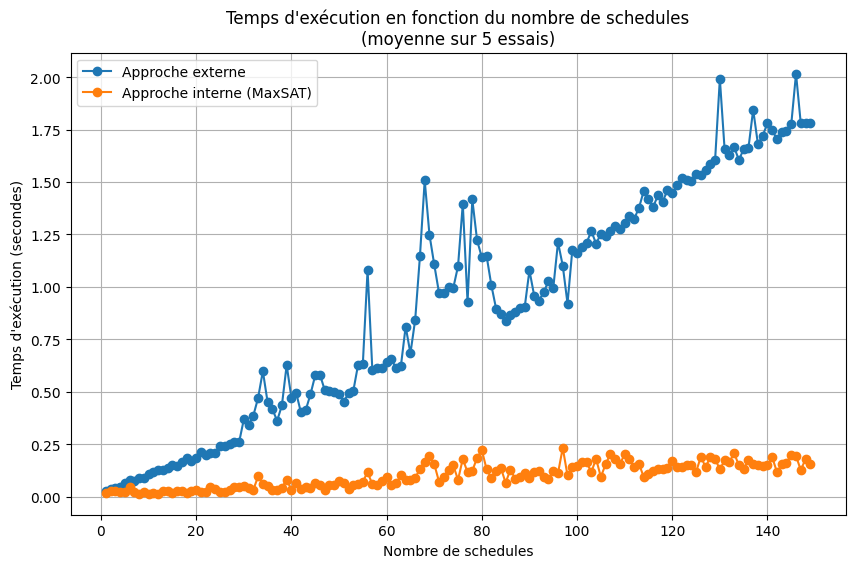

In [21]:
# --- Paramètres du benchmark ---
num_iterations = 5  # Nombre de répétitions pour chaque nombre de schedules
external_times = []  # Temps d'exécution moyen pour l'approche externe (gophersat)
internal_times = []  # Temps d'exécution moyen pour l'approche interne (Glucose3/MaxSAT)
num_schedules = list(range(1, 150))  # De 1 à 100 fichiers

# --- Boucle sur le nombre de schedules ---
for n in num_schedules:
    ext_total = 0.0
    int_total = 0.0
    
    for i in range(num_iterations):
        print(f"Traitement de {n} schedule(s) - essai {i+1}/{num_iterations}...")
        
        # Génération aléatoire des paramètres à chaque itération
        DURATION = random.choice([15, 30, 60])            # Par exemple, durée entre 1 et 10
        IMPORTANCE = random.randint(1, 5)        # Par exemple, importance entre 0.0 et 1.0
        
        # Nettoyer et générer n fichiers CSV d'emplois du temps
        clear_schedules_dir(SCHEDULES_IMP_DIR)
        generer_schedules(n, 5, SCHEDULES_IMP_DIR)  # Génère schedule1.csv, schedule2.csv, ..., schedule{n}.csv
        
        # --- Approche externe (appel à gophersat.exe) ---
        start_ext = time.perf_counter()
        emplois, jours, horaires = lire_emplois_du_temps(SCHEDULES_IMP_DIR)
        clauses, X_vars, Y_vars = generer_clauses_cnf(emplois, jours, horaires, DURATION, IMPORTANCE)
        best_solutions = resoudre_toutes_les_solutions(Y_vars, clauses, emplois, jours, horaires, DURATION)
        ext_total += time.perf_counter() - start_ext
        
        # --- Approche interne (résolution via Glucose3/MaxSAT) ---
        start_int = time.perf_counter()
        emplois, jours, horaires = lire_emplois_du_temps(SCHEDULES_IMP_DIR)
        clauses_max, X_vars_max, Y_vars_max = generer_cnf_max(emplois, jours, horaires, DURATION, IMPORTANCE)
        best_solutions_max = resoudre_toutes_les_solutions_sat_max(clauses_max, Y_vars_max, emplois, jours, horaires, DURATION)
        int_total += time.perf_counter() - start_int

    # Calcul de la moyenne pour n schedules
    external_times.append(ext_total / num_iterations)
    internal_times.append(int_total / num_iterations)

# --- Tracé des courbes ---
plt.figure(figsize=(10, 6))
plt.plot(num_schedules, external_times, label='Approche externe', marker='o')
plt.plot(num_schedules, internal_times, label='Approche interne (MaxSAT)', marker='o')
plt.xlabel('Nombre de schedules')
plt.ylabel("Temps d'exécution (secondes)")
plt.title(f"Temps d'exécution en fonction du nombre de schedules\n(moyenne sur {num_iterations} essais)")
plt.legend()
plt.grid(True)
plt.show()



On constaste que les temps d'éxécution sont des fonctions linéaire du nombre d'emploi du temps, avec une croissance beaucoup plus lente avec MaxSAT.
On en conclut que l'approche MaxSAT est la plus efficace.